In [46]:
# importando as bibliotecas 

import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])


In [29]:
gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])

# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)


In [30]:
# estados da união 
estados = {"AC": "Acre","AL": "Alagoas","AP": "Amapá","AM": "Amazonas","BA": "Bahia","CE": "Ceará","DF": "Distrito Federal","ES": "Espírito Santo","GO": "Goiás","MA": "Maranhão","MT": "Mato Grosso","MS": "Mato Grosso do Sul","MG": "Minas Gerais","PA": "Pará","PB": "Paraíba","PR": "Paraná","PE": "Pernambuco","PI": "Piauí","RJ": "Rio de Janeiro","RN": "Rio Grande do Norte","RS": "Rio Grande do Sul","RO": "Rondônia","RR": "Roraima","SC": "Santa Catarina","SP": "São Paulo","SE": "Sergipe","TO": "Tocantins"}


In [31]:
siglas_para_regioes = {
    'SE':'Sudeste',
    'S' :'Sul',
    'N' : 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro-oeste'
}

In [32]:
# trocando o nome de siglas para o nome dos estados
gas_eta['Estado - Sigla']=gas_eta['Estado - Sigla'].apply(lambda x:estados[x])
gas_eta['Regiao - Sigla']=gas_eta['Regiao - Sigla'].apply(lambda x:siglas_para_regioes[x])
gas_eta.rename(columns={'Estado - Sigla':'Estado','Regiao - Sigla':'regiao'},inplace=True)

In [33]:
media_por_estado=gas_eta.pivot_table(columns='Produto',index='Estado',values='Valor de Venda', aggfunc='mean')


In [93]:
# Merge dos dados com as geometrias dos estados
estados_merged = brasil_estados.merge(media_gasolina, left_on='NM_UF', right_on='Estado')
estados_merged

,CD_UF,NM_UF,SIGLA,NM_REGIAO,geometry,GASOLINA
0,11,Rondônia,RO,Norte,"POLYGON ((-62.86662 -7.97587, -62.86017 -7.982...",5.899349
1,12,Acre,AC,Norte,"POLYGON ((-73.16550 -7.34166, -73.05480 -7.381...",6.121221
2,13,Amazonas,AM,Norte,"POLYGON ((-67.32609 2.02971, -67.31682 2.00125...",6.361536
3,14,Roraima,RR,Norte,"POLYGON ((-60.20051 5.26434, -60.19828 5.26045...",5.858431
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-46.43676 -1.01905, -46.43723 ...",5.534913
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",5.016203
6,17,Tocantins,TO,Norte,"POLYGON ((-48.35878 -5.17008, -48.35617 -5.171...",5.672265
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.66115 -2.98018, -44.66157 ...",5.309018
8,22,Piauí,PI,Nordeste,"POLYGON ((-41.78076 -2.76078, -41.77935 -2.764...",5.425145
9,23,Ceará,CE,Nordeste,"POLYGON ((-40.49582 -2.78541, -40.49242 -2.787...",5.604549


Estado
Amapá                  5.016203
Paraíba                5.204698
Sergipe                5.244855
Minas Gerais           5.257036
São Paulo              5.261490
Pernambuco             5.273448
Maranhão               5.309018
Mato Grosso do Sul     5.336538
Rio Grande do Sul      5.346160
Mato Grosso            5.374283
Goiás                  5.383053
Piauí                  5.425145
Distrito Federal       5.444763
Paraná                 5.450938
Rio de Janeiro         5.497324
Espírito Santo         5.511539
Santa Catarina         5.531759
Pará                   5.534913
Bahia                  5.546381
Ceará                  5.604549
Tocantins              5.672265
Rio Grande do Norte    5.672964
Alagoas                5.674847
Roraima                5.858431
Rondônia               5.899349
Acre                   6.121221
Amazonas               6.361536
Name: GASOLINA, dtype: float64

In [94]:
def mapa_estados(obj,coluna,corX,corY,titulo):
    estados_merged = brasil_estados.merge(obj, left_on='NM_UF', right_on=coluna)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [0.6, 0.2]})# criar figura
    cor_grafico = LinearSegmentedColormap.from_list('CustomColors', [corX,corY], N=27)# cor do gráfico de barras
    
    #gráfico da bandeira
    estados_merged.plot(column=obj.name, cmap=LinearSegmentedColormap.from_list('CustomColors',[corX,corY]), legend=False, ax=axes[0])# gráfico bandeira
    axes[0].set_xticks([])# configurações do mapa
    axes[0].set_yticks([])
    axes[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    
    #gráfico de barras
    adicionar_rotulos(axes[1],plt.barh(obj.index,obj.to_list(), color=custom_cmap(np.linspace(0, 1, 27))),font=10)# gráfico de barras
    axes[1].set_xticks([])# configurações do gráfico de barras
    axes[1].set_yticks(obj.index.to_list(),obj.index.to_list(),color=corY,fontweight= 'bold',fontsize=11, fontstyle= 'italic')
    axes[1].set_xticks([])
    axes[1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

    #Adicionar título centralizado
    fig.suptitle(titulo, fontsize=20, fontweight='bold', color='maroon',fontstyle= 'italic', ha='center')
    plt.tight_layout  # Para acomodar o título acima dos gráficos
    plt.show()

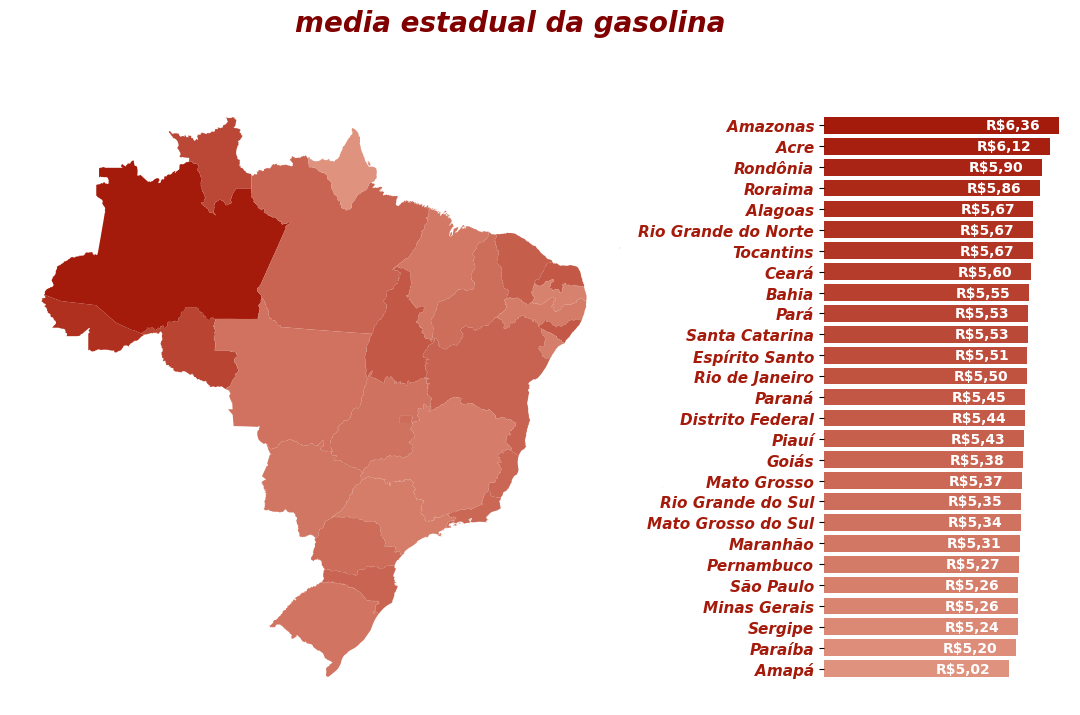

In [98]:
mapa_estados(media_por_estado['GASOLINA'].sort_values(),'Estado','#df927e','#a51b0b','media estadual da gasolina')

In [45]:
# Criar uma nova figura para Gasolina Aditivada
# Cria uma figura e um objeto GridSpec com 2 linhas e 2 colunas

# Adiciona subplots ao GridSpec
ax_bar = fig.add_subplot(gs[1])
ax_map = fig.add_subplot(gs[0])
custom_cmap = LinearSegmentedColormap.from_list('CustomColors', [corX,corY], N=27)

# Plotar mapas coropléticos com as cores correspondentes (ajustando tamanho)
adicionar_rotulos(plt,plt.barh(media_gasolina.index,media_gasolina.to_list(), color=custom_cmap(np.linspace(0, 1, 27))),font=10)
ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Plotar gráfico de barras horizontais para Gasolina Aditivada (ajustando tamanho)


# Define a cor gradual usando cmap, começando em red e indo até gray



# Remover a legenda do gráfico de barras horizontal
ax_bar.set_xticks([])
ax_bar.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Adicionar os valores nas barras do gráfico de barras


# Adicionar título centralizado
fig.suptitle('Análise do Preço Médio em R$/litro da Gasolina Aditivada por Estado', fontsize=20, fontweight='bold', color='maroon',fontstyle= 'italic', ha='center')


plt.show()

NameError: name 'PLT' is not defined

In [79]:

def quadro(s_p=[],cor='grey'):
    quadro=list(filter(lambda x: x not in s_p,['right','top','bottom','left']))
    plt.gca().spines[quadro].set_visible(False)
    if s_p!= []:
        plt.gca().spines[s_p].set_color(cor)


In [12]:
media_gasolina=media_por_estado['GASOLINA'].sort_values()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

fig=plt.figure(figsize=(10,8))
g1=plt.subplot(1,2,1)
estados_merged.plot(column='GASOLINA',cmap=LinearSegmentedColormap.from_list('CustomColors',['#f7dad2','#a51b0b'], N=27))g2=plt.subplot(1,2,2)

custom_colors = ['#f7dad2', '#a51b0b']
n_segments = 27
custom_cmap = LinearSegmentedColormap.from_list('CustomColors',['#f7dad2', '#a51b0b'], N=27)

adicionar_rotulos(g1,plt.barh(media_gasolina.index,media_gasolina.to_list(), color=custom_cmap(np.linspace(0, 1, 27))),cor='white',font=10)

# g2.set_axis_off()

# Criando a paleta de cores personalizada

# Dados para o gráfico de barras


# Criando um array de posições para as barras
x_pos = np.arange(len(categorias))

# Criando o gráfico de barras


# Definindo os rótulos no eixo x
# rotulos(g1,media_gasolina,custom_colors[1],'')


# Definindo um título e rótulos dos eixos

# Exibindo o gráfico
plt.show()


SyntaxError: invalid syntax (1147323451.py, line 7)